# Introduction

In this project we are going to explore a dataset from Data Science Stack Exchange to determine the type of content that a Data Science Education Company should make based on users' interests on Stack Exchange.

Our dataset is collected after running the following query on the [Stack Exchange Data Explorer](https://data.stackexchange.com/datascience/query/new):

~~~
SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
~~~

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
questions = pd.read_csv('2019_questions.csv', parse_dates=["CreationDate"])

In [3]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We see that only FavoriteCount has missing values (1407/8839). It most likely just means that most of the posts are not on any user's favorite list, which is reasonable. 

In [4]:
for c in questions.columns:
    print(c+': '+str(questions[c].isna().sum()))

Id: 0
CreationDate: 0
Score: 0
ViewCount: 0
Tags: 0
AnswerCount: 0
FavoriteCount: 7432


In [5]:
questions['FavoriteCount'].value_counts(dropna=False)

NaN      7432
 1.0      953
 2.0      205
 0.0      175
 3.0       43
 4.0       12
 5.0        8
 6.0        4
 7.0        4
 11.0       1
 8.0        1
 16.0       1
Name: FavoriteCount, dtype: int64

# Cleaning the Data

In [6]:
questions['FavoriteCount'].fillna(0,inplace=True)

We decide to fill the missing values of FavoriteCount with 0 because they are on 0 user's favorite list.

In [7]:
def clean_tag(tag):
    clean = tag.replace('><',',')
    clean = clean.replace('<','').replace('>','').split(',')
    return clean

In [8]:
questions['Tags'] = questions['Tags'].apply(clean_tag)

In [9]:
questions['Tags'].head()

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object

We cleaned the Tags column and turn it in to a list of DS topics.

# Most used and most viewed Tags

In [10]:
tags_used = {}
for tag_list in questions['Tags']:
    for tag in tag_list:
        if tag not in tags_used:
            tags_used[tag] = 1
        else:
            tags_used[tag] += 1

In [11]:
tags_used_count = pd.DataFrame.from_dict(tags_used, orient="index")
tags_used_count.rename(columns={0: "Count"}, inplace=True)
most_used = tags_used_count.sort_values('Count',axis=0,ascending=False).head(10)

In [12]:
print(most_used)

                  Count
machine-learning   2693
python             1814
deep-learning      1220
neural-network     1055
keras               935
classification      685
tensorflow          584
scikit-learn        540
nlp                 493
cnn                 489


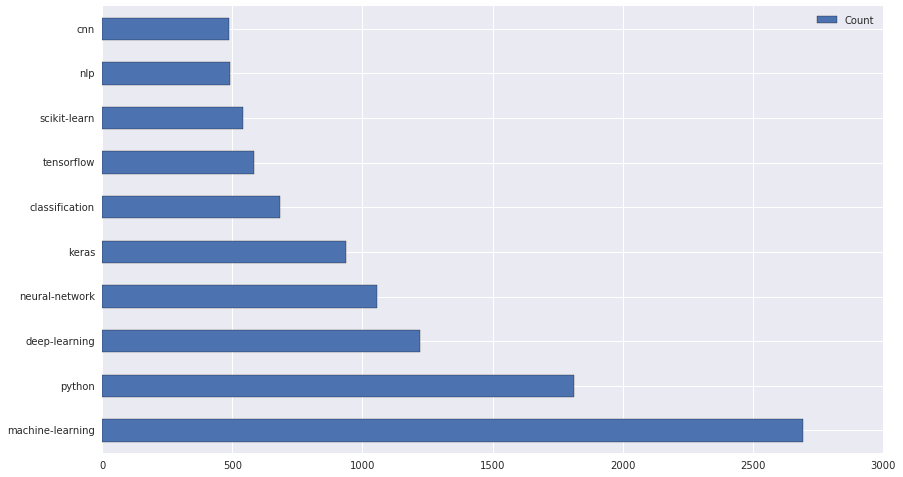

In [13]:
most_used.plot(kind='barh',figsize=(14,8))

In [14]:
tags_viewed = {}
for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag not in tags_viewed:
            tags_viewed[tag] = row['ViewCount']
        else:
            tags_viewed[tag] += row['ViewCount']

In [15]:
tags_viewed_count = pd.DataFrame.from_dict(tags_viewed, orient="index")
tags_viewed_count.rename(columns={0: "Count"}, inplace=True)
most_viewed = tags_viewed_count.sort_values('Count',axis=0,ascending=False).head(10)

In [16]:
print(most_viewed)

                   Count
python            537585
machine-learning  388499
keras             268608
deep-learning     233628
pandas            201787
neural-network    185367
scikit-learn      128110
tensorflow        121369
classification    104457
dataframe          89352


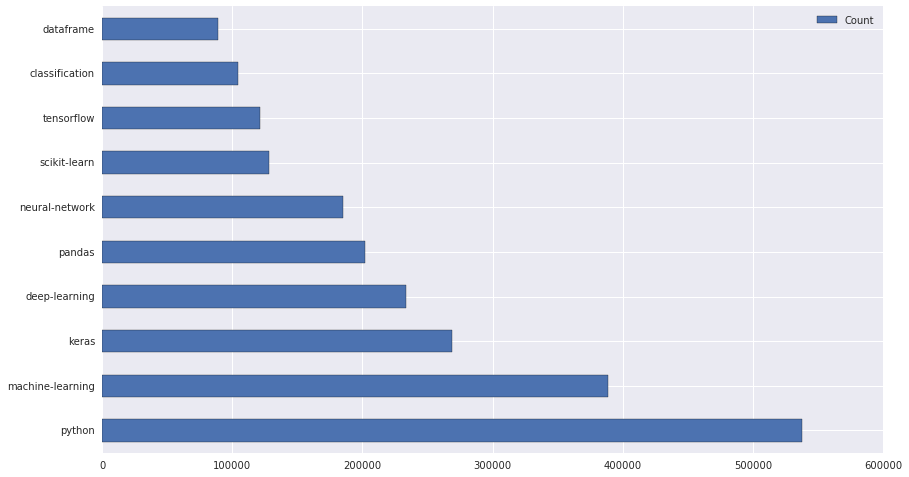

In [17]:
most_viewed.plot(kind='barh',figsize=(14,8))

In [18]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6617f47b8>],
      dtype=object)

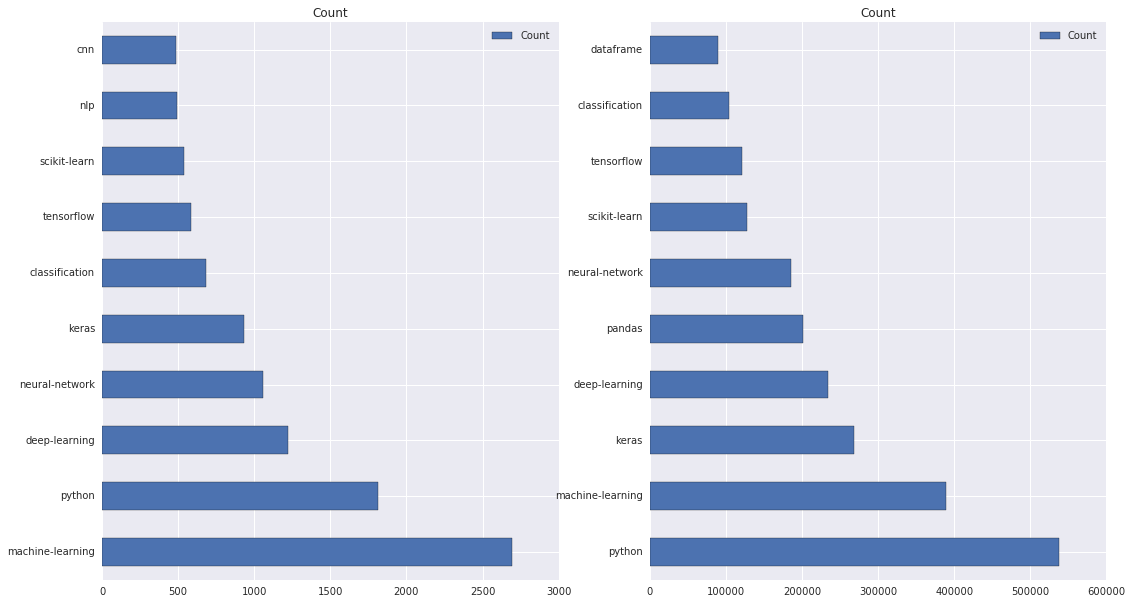

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((18,10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

# Tag associations

In [20]:
tag_associations = pd.DataFrame(index=list(tags_used_count.index), columns=list(tags_used_count.index))

In [21]:
tag_associations.fillna(0,inplace=True)

In [22]:
for tag in questions['Tags']:
    tag_associations.loc[tag,tag]+=1

In [23]:
associations_most_used = tag_associations.loc[most_used.index,most_used.index]

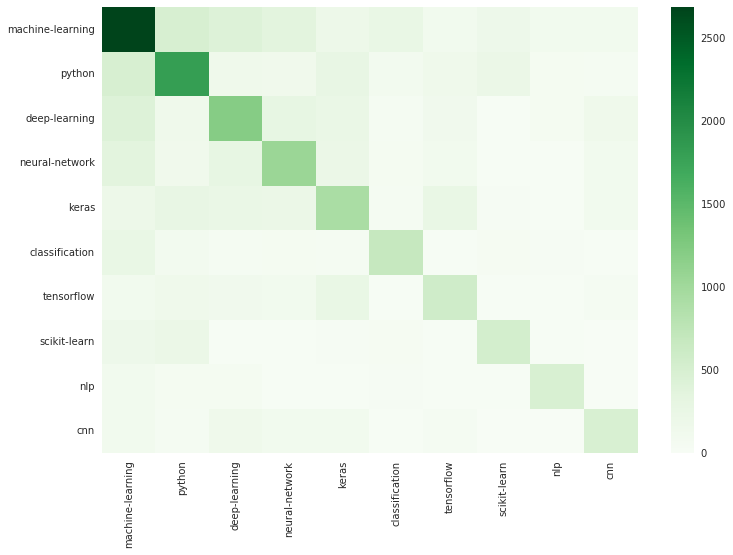

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(associations_most_used, cmap="Greens", annot=False)

We see that the most used tags have the strongest relationships with the other most used tags, although it may be due to the fact that they are the most used tags, so they often used together a lot. For example, deep-learning and neural-network are very similar, and are both under the umbrella of machine-learning.

# Deep Learning Interest

In [25]:
all_q = pd.read_csv('all_questions.csv', parse_dates=["CreationDate"])

In [26]:
all_q["Tags"] = all_q["Tags"].apply(clean_tag)

In [27]:
dl_topics = ["lstm", "cnn", "scikit-learn", "tensorflow","keras", "neural-network", "deep-learning"]
def is_dl(tags):
    for tag in tags:
        if tag in dl_topics:
            return 1
    return 0

In [28]:
all_q['is_dl'] = all_q['Tags'].apply(is_dl)

In [29]:
all_q['is_dl'].value_counts()

0    13758
1     7818
Name: is_dl, dtype: int64

In [30]:
all_q.head()

,Id,CreationDate,Tags,is_dl
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


## Interests in DL group by Year Month

In [31]:
import datetime as dt
all_q['yearmonth'] = all_q['CreationDate'].dt.year*100+all_q['CreationDate'].dt.month

In [32]:
all_q['yearmonth'].head()

0    201902
1    201902
2    201902
3    201902
4    201902
Name: yearmonth, dtype: int64

In [33]:
yearmonth = all_q.groupby('yearmonth').agg({"is_dl": ['sum', 'size']})
yearmonth.columns = ['dl_q','all_q']
yearmonth.reset_index(inplace=True)

In [34]:
yearmonth.head()

,yearmonth,dl_q,all_q
0,201405,2,58
1,201406,7,99
2,201407,7,76
3,201408,5,65
4,201409,1,48


In [35]:
yearmonth['dl_rate'] = yearmonth['dl_q']/yearmonth['all_q']*100

In [36]:
yearmonth.head()

,yearmonth,dl_q,all_q,dl_rate
0,201405,2,58,3.448276
1,201406,7,99,7.070707
2,201407,7,76,9.210526
3,201408,5,65,7.692308
4,201409,1,48,2.083333


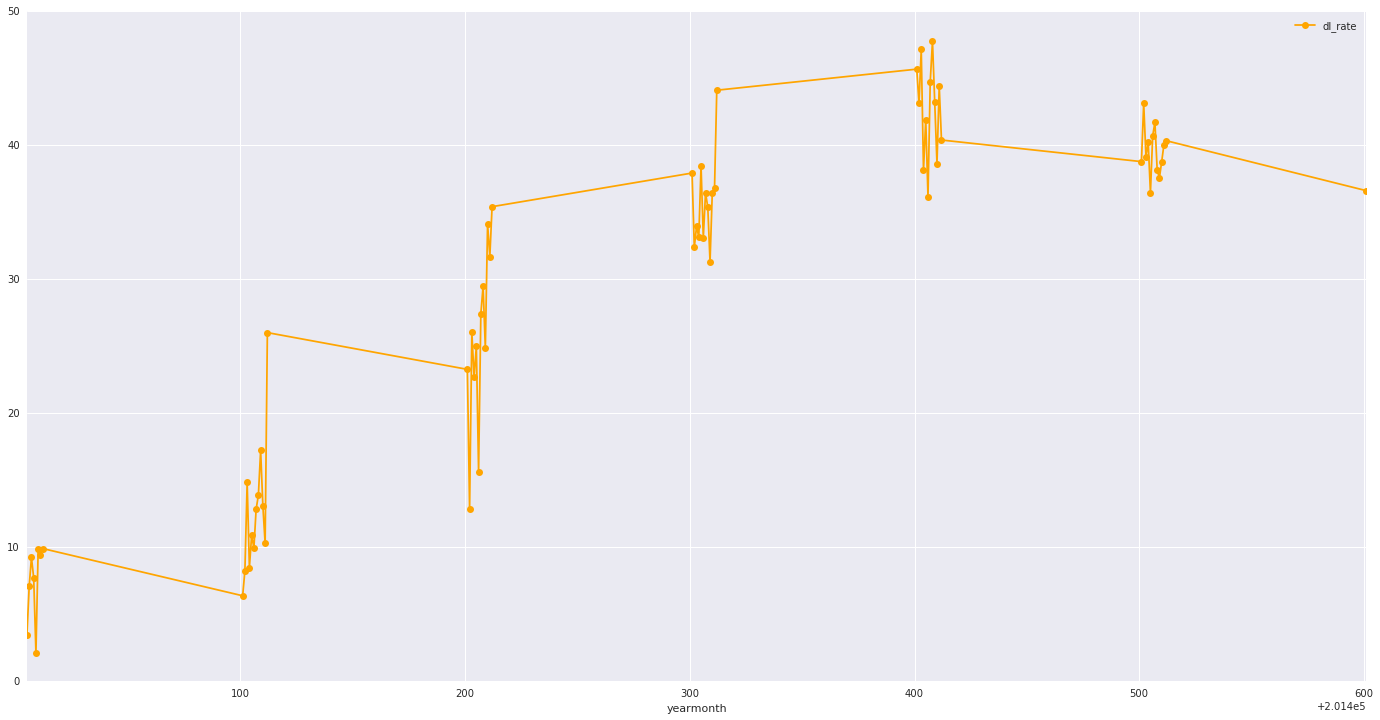

In [37]:
ax1 = yearmonth.plot(x='yearmonth',y='dl_rate',kind='line',linestyle='-',marker='o', color='orange',figsize=(24,12))

We can clearly see an uptrend in the interest for DL over time. However, it seems to have peaked in the most recent years.

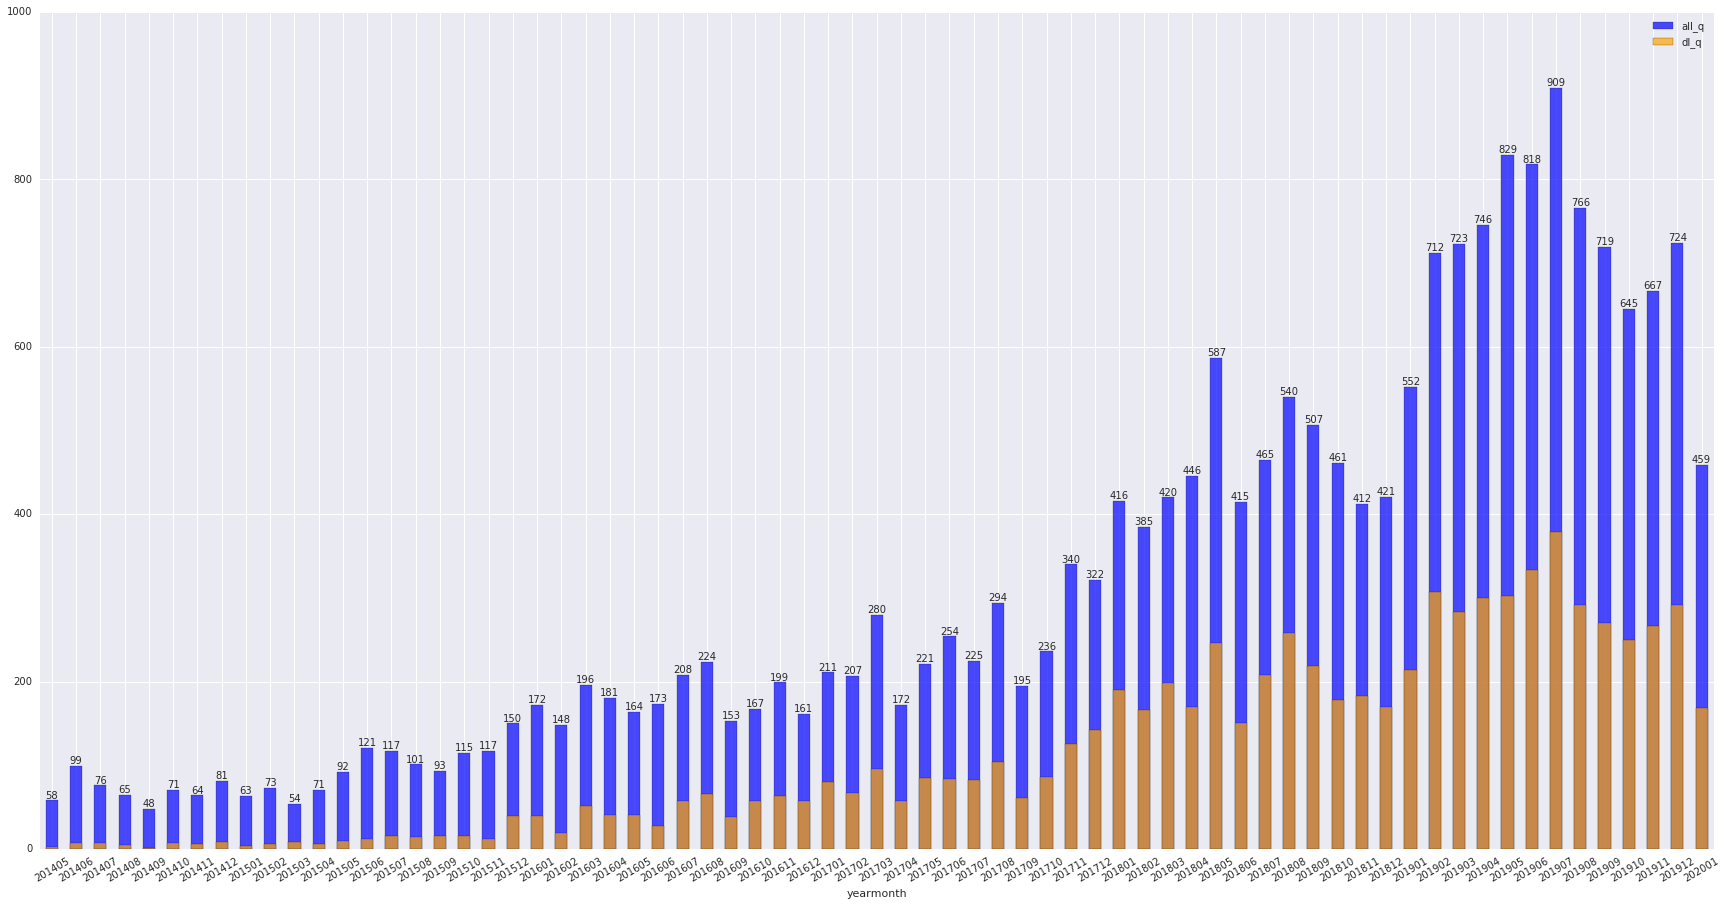

In [38]:
ax2 = yearmonth.plot(x='yearmonth', y='all_q',kind='bar',alpha=0.7,rot=40,color='blue')
ax3 = yearmonth.plot(x='yearmonth', y='dl_q',ax=ax2,kind='bar',alpha=0.7,rot=30,figsize=(30,15), color='orange')

        
for idx, t in yearmonth["all_q"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")


This is a bar chart showing the number of DL questions and number of ALL questions on Stack Exchange in different yearmonths. We can see that overall they both trended upward with time. However, it's difficult to conclude that interests in deep learning are still growing as its proportion to all questions seem to have peaked and consolidated.